In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install konlpy
import numpy as np
from collections import Counter
from time import time
import pickle
import os
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 460kB 50.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
def read_data(filename):
    with open(filename, "r", encoding = "utf-8") as f:
        data = [line.split("\t") for line in f.read().splitlines()]
        data = data[1:]
    
    return data

train_data = read_data("/content/drive/MyDrive/Python/ratings_train.txt")
train_df = pd.DataFrame(train_data) # pandas 사용
test_data = read_data("/content/drive/MyDrive/Python/ratings_test.txt")
test_df = pd.DataFrame(test_data) # pandas 사용

In [ ]:
print('훈련용 문장 개수 :',len(train_df))
train_df.head()

훈련용 리뷰 개수 : 150000


,0,1,2
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print('테스트용 문장 개수 :',len(test_df))
test_df.head()

테스트용 리뷰 개수 : 50000


,0,1,2
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
# 칼럼명 변경
train_df.columns=['ID','document','label']
test_df.columns=['ID','document','label']

In [ ]:
# 중복 확인
train_df['document'].nunique(), train_df['label'].nunique()

(146183, 2)

In [ ]:
# 중복 제거
train_df.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
print('총 훈련용 문장의 수 :',len(train_df))

총 샘플의 수 : 146183


  label  count
0     0  73342
1     1  72841


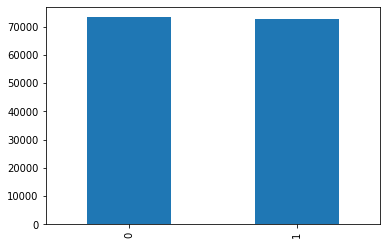

In [ ]:
train_df['label'].value_counts().plot(kind = 'bar')
print(train_df.groupby('label').size().reset_index(name = 'count'))

In [ ]:
print(train_df.isnull().sum())

ID          0
document    0
label       0
dtype: int64


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df[:5]

,ID,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
train_df['document'].replace('', np.nan, inplace=True)
print(train_df.isnull().sum())

ID            0
document    392
label         0
dtype: int64


In [ ]:
train_df = train_df.dropna(how = 'any')
print(len(train_df))

145791


In [ ]:
test_df.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_df['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_df = test_df.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_df))

전처리 후 테스트용 샘플의 개수 : 48995


In [ ]:
stop_words = ['의','가','이','은','들','는','좀','아','것','잘','걍','있','되','과','수','보','주','등','도','를','으로','자','에','와','한','하다','하','이',	'있',	'하',	'것',	'들',	'그',	'되',	'수',	'이',	'보',	'않',	'없',	'나',	'사람',	'주',	'아니',	'등',	'같',	'우리',	'때',	'년',	'가',	'한',	'지',	'대하',	'오',	'말',	'일',	'그렇',	'위하',	'때문',	'그것',	'두',	'말하',	'알',	'그러나',	'받',	'못하',	'일',	'그런',	'또',	'문제',	'더',	'사회',	'많',	'그리고',	'좋',	'크',	'따르',	'중',	'나오',	'가지',	'씨',	'시키',	'만들',	'지금',	'생각하',	'그러',	'속',	'하나',	'집',	'살',	'모르',	'적',	'월',	'데',	'자신',	'안',	'어떤',	'내',	'내',	'경우',	'명',	'생각',	'시간',	'그녀',	'다시',	'이런',	'앞',	'보이',	'번',	'나',	'다른',	'어떻',	'여자',	'개',	'전',	'들',	'사실',	'이렇',	'점',	'싶',	'말',	'정도',	'좀',	'원',	'잘',	'통하',	'소리',	'놓']

In [ ]:
X_train = []
okt = Okt()
for docu in train_df['document']:
    temp_X_train = []
    temp_X_train = okt.morphs(docu, stem=True) # 토큰화
    temp_X_train = [word for word in temp_X_train if not word in stop_words] # 불용어 제거
    X_train.append(temp_X_train)

In [ ]:
X_test = []
okt = Okt()
for docu in test_df['document']:
    temp_X_test = []
    temp_X_test = okt.morphs(docu, stem=True) # 토큰화
    temp_X_test = [word for word in temp_X_test if not word in stop_words] # 불용어 제거
    X_test.append(temp_X_test)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '만': 13, '같다': 14, '진짜': 15, '로': 16, '아니다': 17, '않다': 18, '에서': 19, '만들다': 20, '나오다': 21, '연기': 22, '평점': 23, '최고': 24, '인': 25, '스토리': 26, '못': 27, '왜': 28, '드라마': 29, '게': 30, '감동': 31, '보고': 32, '이렇다': 33, '고': 34, '아깝다': 35, '배우': 36, 'ㅋㅋ': 37, '감독': 38, '거': 39, '그냥': 40, '재미있다': 41, '요': 42, '재미': 43, '내용': 44, '뭐': 45, '까지': 46, '주다': 47, '자다': 48, '하고': 49, '지루하다': 50, '재미없다': 51, '쓰레기': 52, '네': 53, '모르다': 54, '가다': 55, '들다': 56, '그렇다': 57, '싶다': 58, '작품': 59, '사랑': 60, '알다': 61, '마지막': 62, '볼': 63, '이건': 64, '저': 65, '완전': 66, '오다': 67, 'ㅋ': 68, 'ㅠㅠ': 69, '많다': 70, '처음': 71, 'ㅋㅋㅋ': 72, '장면': 73, '액션': 74, '주인공': 75, '이렇게': 76, '안되다': 77, '걸': 78, '차다': 79, '나다': 80, '최악': 81, '돈': 82, '이야기': 83, '넘다': 84, '느낌': 85, '임': 86, '연출': 87, 'ㅡㅡ': 88, '라': 89, '인데': 90, '듯': 91, '끝': 92, '명작': 93, '좋아하다': 94, '별로': 95, '역시': 96, '받다': 97, '기': 98, '많이': 99, '남다': 100, '별': 

In [ ]:
threshold = 3
total_count = len(tokenizer.word_index) # 단어의 수
rare_count = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_count = rare_count + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43685
등장 빈도가 2번 이하인 희귀 단어의 수: 24335
단어 집합에서 희귀 단어의 비율: 55.70561977795582
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.0462321451154777


In [ ]:
vocab_size = total_count - rare_count + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19352


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[407, 16, 223, 604], [875, 409, 33, 548, 2, 179, 1390, 23, 903, 620, 19], [346, 2384, 1, 2255, 5608, 3, 186, 10]]


In [ ]:
y_train = np.array(train_df['label'],dtype='float32')
y_test = np.array(test_df['label'],dtype='float32')

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145310
145310


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 10.066994700984102


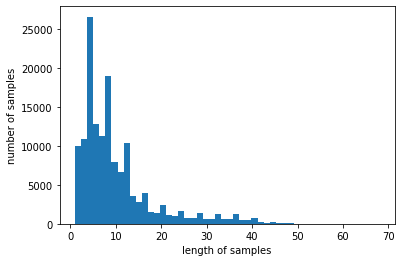

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 25
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 92.86490950381942


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
3633/3633 [==============================] - 184s 50ms/step - loss: 0.4320 - acc: 0.7921 - val_loss: 0.3487 - val_acc: 0.8464

Epoch 00001: val_acc improved from -inf to 0.84643, saving model to best_model.h5
Epoch 2/15
3633/3633 [==============================] - 177s 49ms/step - loss: 0.2896 - acc: 0.8761 - val_loss: 0.3452 - val_acc: 0.8527

Epoch 00002: val_acc improved from 0.84643 to 0.85273, saving model to best_model.h5
Epoch 3/15
3633/3633 [==============================] - 176s 49ms/step - loss: 0.2324 - acc: 0.9038 - val_loss: 0.3729 - val_acc: 0.8472

Epoch 00003: val_acc did not improve from 0.85273
Epoch 4/15
3633/3633 [==============================] - 180s 50ms/step - loss: 0.1868 - acc: 0.9248 - val_loss: 0.3978 - val_acc: 0.8413

Epoch 00004: val_acc did not improve from 0.85273
Epoch 5/15
3633/3633 [==============================] - 174s 48ms/step - loss: 0.1461 - acc: 0.9441 - val_loss: 0.4990 - val_acc: 0.8394

Epoch 00005: val_acc did not improve from 0

In [ ]:
loaded_model = load_model('best_model.h5')

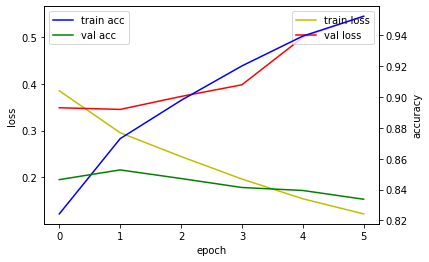

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 12s 8ms/step - loss: 0.3507 - acc: 0.8467

 테스트 정확도: 0.8467


In [ ]:
def sentiment_predict2(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    return 1
  else:
    return 0

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Python/ko_data.csv", sep=",", encoding="utf-8")
data.to_csv("/content/drive/MyDrive/Python/ko_data.csv", sep=",", index=False)

In [ ]:
data['Predicted'] = ''

In [ ]:
for i in range(0,len(data)): 
  data.loc[i,'Predicted'] = sentiment_predict2(data.loc[i,'Sentence'])

In [ ]:
data.drop(['Sentence'],axis='columns',inplace=True)

In [ ]:
data.head()

In [ ]:
data.to_csv("/content/drive/MyDrive/Python/sample_kor_5.csv", sep=",", index=False)